In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

In [2]:
def RK4_with_treatment_adaptive_mesh(f, f_treat, x0, t, h0, args=()):
    
    hmin = 0.00001
    hmax = 0.001
    
    t0 = 0
    tf = t
    
    xs = [x0]
    ts = [t0]
    
    hi = h0
    xi = x0
    ti = t0
    Di = f_treat(t0)
    
    tol = 0.00001    # this tolerance takes 12 minutes but gets accurate results
    
    while ti < tf:
        
        k1 = hi * f(xi, ti, Di, *args)
        k2 = hi * f(xi + 0.5 * k1, ti + 0.5 * hi, Di, *args)
        k3 = hi * f(xi + 0.5 * k2, ti + 0.5 * hi, Di, *args)
        k4 = hi * f(xi + k3, ti + hi, Di, *args)
    
        xi_new = xi + (1.0 / 6.0)*(k1 + 2 * k2 + 2 * k3 + k4)
        
        if np.all(np.abs(xi_new-xi)<tol):
            
            ti = ti + hi
            xi = xi_new
            xs.append(xi)
            ts.append(ti)
            Di = f_treat(ti)
            
            hi = min(hmax,hi*10)
            
        elif (np.any(np.abs(xi_new-xi)>tol))&(hi>0.00001): 
            
            hi = max(hmin,hi/10)
            
        elif (np.any(np.abs(xi_new-xi)>tol))&(hi==0.00001):
            
            ti = ti + hi
            xi = xi_new
            xs.append(xi)
            ts.append(ti)
            Di = f_treat(ti)
            
            hi = hi
        
    return np.array(ts), np.array(xs)

In [3]:
def MyFullModel(X, t, D, l, kD, rho_C3, aC, g, gT, d1, s15, k5, d2, s25, v, a3, d3, rho_3C, eps, Dopt, n, a51, d, rho_5C, a52, s5C):
    
    x1, x2, x3, x5 = X
    
    dotx1 = ( 1 - l*D*np.exp(-kD*x3) + rho_C3*((x3*(1+aC))/(x3+aC)) ) * x1 - g*x1*(x1+x2) - gT*x1 - d1*D*np.exp(-kD*x3)*x1 \
            - s15*x5*np.exp(-k5*x3)*x1 
    
    dotx2 = l*D*np.exp(-kD*x3)*x1 + ( 1 + rho_C3*((x3*(1+aC))/(x3+aC)) ) * x2 - g*x2*(x1+x2) - gT*x2 - d2*D*np.exp(-kD*x3)*x2 \
            - s25*x5*np.exp(-k5*x3)*x2
    
    dotx3 = v*( (np.exp(a3*D)-1) / (np.exp(a3)-1) )*(1-x3) - d3*D*x3 + rho_3C*(x1+x2)*(1-x3) - eps*x3
    
    b = Dopt + ( np.log(n) / (a51+n*a51) )
    
    dotx5 = d * ( (  np.exp(a51*b) + np.exp(-n*a51*b)  ) / (  np.exp(-a51*(D-b)) + np.exp(n*a51*(D-b))  ) ) \
            - d*x5 + rho_5C*(  (x1+x2)  /  (a52+x1+x2)  )*x5 - s5C*(x1+x2)*x5 
    
    return np.array([dotx1, dotx2, dotx3, dotx5])

In [4]:
#### TREATMENT FREE PARAMS ####

g = 0.35
gT = 0.08

rho_C3 = 1.2
aC = 0.2
#rho_3C = 0.3 was used first time, hopefully results are still good like this...
rho_3C = 3

eps=0.01

s15 = 0.5
k5 = 0.22

d = 0.23

rho_5C = 0.689
a52 = 0.0000225
s5C = 5625




#### TREATMENT PARAMS ####

l = 2*10**(-3)
kD = 0.7 

s25 = 0.25

v = 4
a3 = 8.84
d3 = 1

Dopt = 0.5
n = 34
a51 = 0.3

d1 = 800
d2 = 80

In [5]:
######################################################################################################################
######################################################################################################################

# Initial time to treat were found by first simulating without treatment and using the find_nearest function: 

# def find_nearest(array, value):
#     array = np.asarray(array)
#     idx = (np.abs(array - value)).argmin()
#     return idx

# to find the time point at which x1=0.1. 

# Time for follow up treatment was found by simulating with one round of treatment and then using find_nearest again
# to obtain the time point when the total cancer size was 0.1. 

######################################################################################################################
######################################################################################################################

def f_treat_3mMTD_x2(t,t0=7.73,t1=15.72,num_weeks=12,week_length=0.01,decay=500):
    
    tmax0 = t0+num_weeks*week_length
    tmax1 = t1+num_weeks*week_length
    
    if t<t0:
        return 0
    if t>=tmax1:
        return 0
    if (t>=tmax0)&(t<t1):
        return 0
    for i in range(num_weeks):
        if (t>=t0+i*(week_length))&(t<t0+(i+1)*(week_length))&( (i+1)%4!=0 ):
            return np.exp( decay*(t0+i*(week_length)-t) )
        elif (t>=t0+i*(week_length))&(t<t0+(i+1)*(week_length))&( (i+1)%4==0 ):
            return 0
    for i in range(num_weeks):
        if (t>=t1+i*(week_length))&(t<t1+(i+1)*(week_length))&( (i+1)%4!=0 ):
            return np.exp( decay*(t1+i*(week_length)-t) )
        elif (t>=t1+i*(week_length))&(t<t1+(i+1)*(week_length))&( (i+1)%4==0 ):
            return 0

In [6]:
%%time

t = 25
h = 0.001
x0 = [0.0001,0.0,0.0,1.0]


# rs = responsive stroma
# ui = unresponsive immune
# us = unresponsive stroma
# ri = responsive immune


RK4_MyModel = RK4_with_treatment_adaptive_mesh(MyFullModel, f_treat_3mMTD_x2, x0, t, h, args = (l, kD, rho_C3, aC, g, gT, d1, s15, k5, d2, s25, v, a3, d3, rho_3C, eps, Dopt, n, a51, d, rho_5C, a52, s5C))
ts_MTD2_rs_ui, xs = RK4_MyModel
x1_MTD2_rs_ui, x2_MTD2_rs_ui, x3_MTD2_rs_ui, x5_MTD2_rs_ui = xs.T

Wall time: 7min 55s


In [7]:
#### TREATMENT FREE PARAMS ####

g = 0.35
gT = 0.08

rho_C3 = 1.2
aC = 0.2
#rho_3C = 0.3 was used first time, hopefully results are still good like this...
rho_3C = 3

eps=0.01

s15 = 0.5
k5 = 0.22

d = 0.23

rho_5C = 0.689
a52 = 0.0000225
s5C = 5625




#### TREATMENT PARAMS ####

l = 2*10**(-3)
kD = 0.7 

s25 = 0.25

v = 4
a3 = 8.84
d3 = 1

Dopt = 0.5
n = 34
a51 = 0.3

d1 = 800
d2 = 80

In [8]:
def f_treat_3mLDM_x2(t,t0=7.73,t1=17.2,num_weeks=12,week_length=0.01,decay=500):
    
    num_days = 12*7
    tmax0 = t0+num_weeks*week_length
    tmax1 = t1+num_weeks*week_length
    
    if t<t0:
        return 0
    if t>=tmax1:
        return 0
    if (t>=tmax0)&(t<t1):
        return 0
    for i in range(num_days):
        if (t>=t0+i*(week_length/7))&(t<t0+(i+1)*(week_length/7)):
            return 0.3*np.exp( decay*(t0+i*(week_length/7)-t) )
    for i in range(num_days):
        if (t>=t1+i*(week_length/7))&(t<t1+(i+1)*(week_length/7)):
            return 0.3*np.exp( decay*(t1+i*(week_length/7)-t) )
        

In [9]:
t = 25
h = 0.001
x0 = [0.0001,0.0,0.0,1.0]

RK4_MyModel = RK4_with_treatment_adaptive_mesh(MyFullModel, f_treat_3mLDM_x2, x0, t, h, args = (l, kD, rho_C3, aC, g, gT, d1, s15, k5, d2, s25, v, a3, d3, rho_3C, eps, Dopt, n, a51, d, rho_5C, a52, s5C))
ts_LDM2_rs_ui, xs = RK4_MyModel
x1_LDM2_rs_ui, x2_LDM2_rs_ui, x3_LDM2_rs_ui, x5_LDM2_rs_ui = xs.T

In [10]:
#### TREATMENT FREE PARAMS ####

g = 0.35
gT = 0.08

rho_C3 = 1.2
aC = 0.2
#rho_3C = 0.3 was used first time, hopefully results are still good like this...
rho_3C = 3

eps=0.01

s15 = 0.5
k5 = 0.22

d = 0.23

rho_5C = 0.689
a52 = 0.0000225
s5C = 5625




#### TREATMENT PARAMS ####

l = 2*10**(-3)
kD = 0.7 

s25 = 0.25

v = 0.4
a3 = 8.84
d3 = 0.1

Dopt = 0.5
n = 11
a51 = 1

d1 = 800
d2 = 80

In [11]:
def f_treat_3mMTD_x2(t,t0=7.73,t1=15.77,num_weeks=12,week_length=0.01,decay=500):
    
    tmax0 = t0+num_weeks*week_length
    tmax1 = t1+num_weeks*week_length
    
    if t<t0:
        return 0
    if t>=tmax1:
        return 0
    if (t>=tmax0)&(t<t1):
        return 0
    for i in range(num_weeks):
        if (t>=t0+i*(week_length))&(t<t0+(i+1)*(week_length))&( (i+1)%4!=0 ):
            return np.exp( decay*(t0+i*(week_length)-t) )
        elif (t>=t0+i*(week_length))&(t<t0+(i+1)*(week_length))&( (i+1)%4==0 ):
            return 0
    for i in range(num_weeks):
        if (t>=t1+i*(week_length))&(t<t1+(i+1)*(week_length))&( (i+1)%4!=0 ):
            return np.exp( decay*(t1+i*(week_length)-t) )
        elif (t>=t1+i*(week_length))&(t<t1+(i+1)*(week_length))&( (i+1)%4==0 ):
            return 0

In [12]:
t = 25
h = 0.001
x0 = [0.0001,0.0,0.0,1.0]

RK4_MyModel = RK4_with_treatment_adaptive_mesh(MyFullModel, f_treat_3mMTD_x2, x0, t, h, args = (l, kD, rho_C3, aC, g, gT, d1, s15, k5, d2, s25, v, a3, d3, rho_3C, eps, Dopt, n, a51, d, rho_5C, a52, s5C))
ts_MTD2_us_ri, xs = RK4_MyModel
x1_MTD2_us_ri, x2_MTD2_us_ri, x3_MTD2_us_ri, x5_MTD2_us_ri = xs.T

In [13]:
#### TREATMENT FREE PARAMS ####

g = 0.35
gT = 0.08

rho_C3 = 1.2
aC = 0.2
#rho_3C = 0.3 was used first time, hopefully results are still good like this...
rho_3C = 3

eps=0.01

s15 = 0.5
k5 = 0.22

d = 0.23

rho_5C = 0.689
a52 = 0.0000225
s5C = 5625




#### TREATMENT PARAMS ####

l = 2*10**(-3)
kD = 0.7 

s25 = 0.25

v = 0.4
a3 = 8.84
d3 = 0.1

Dopt = 0.5
n = 11
a51 = 1

d1 = 800
d2 = 80

In [14]:
def f_treat_3mLDM_x2(t,t0=7.73,t1=17.15,num_weeks=12,week_length=0.01,decay=500):
    
    num_days = 12*7
    tmax0 = t0+num_weeks*week_length
    tmax1 = t1+num_weeks*week_length
    
    if t<t0:
        return 0
    if t>=tmax1:
        return 0
    if (t>=tmax0)&(t<t1):
        return 0
    for i in range(num_days):
        if (t>=t0+i*(week_length/7))&(t<t0+(i+1)*(week_length/7)):
            return 0.3*np.exp( decay*(t0+i*(week_length/7)-t) )
    for i in range(num_days):
        if (t>=t1+i*(week_length/7))&(t<t1+(i+1)*(week_length/7)):
            return 0.3*np.exp( decay*(t1+i*(week_length/7)-t) )

In [15]:
t = 25
h = 0.001
x0 = [0.0001,0.0,0.0,1.0]

RK4_MyModel = RK4_with_treatment_adaptive_mesh(MyFullModel, f_treat_3mLDM_x2, x0, t, h, args = (l, kD, rho_C3, aC, g, gT, d1, s15, k5, d2, s25, v, a3, d3, rho_3C, eps, Dopt, n, a51, d, rho_5C, a52, s5C))
ts_LDM2_us_ri, xs = RK4_MyModel
x1_LDM2_us_ri, x2_LDM2_us_ri, x3_LDM2_us_ri, x5_LDM2_us_ri = xs.T

In [16]:
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

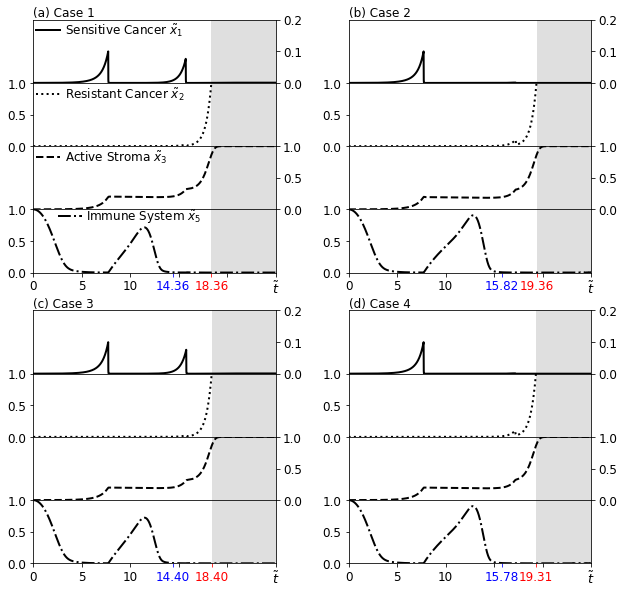

In [17]:
fig, axs = plt.subplots(9, 2, figsize=(10, 10), gridspec_kw={'height_ratios': [1, 1, 1, 1, 0.6, 1, 1, 1, 1],'width_ratios': [1,1]})
axs[4,0].axis('off')
axs[4,1].axis('off')

for i in range(9):
    for j in range(2):
        axs[i,j].set_xticks([0,5,10,15,20,25])
        axs[i,j].set_xticklabels(['0','5','10','15','20','25'],fontsize=12)
        axs[i,j].set_yticks([0,0.5,1])
        axs[i,j].set_yticklabels(['0.0','0.5','1.0'],fontsize=12)

axs[0,0].plot(ts_MTD2_rs_ui, x1_MTD2_rs_ui,'k-',linewidth=2,label=r'Sensitive Cancer $\tilde{x}_1$')
axs[0,0].set_xlim(0,25)
axs[0,0].set_ylim(0,0.2)
axs[0,0].set_xticks([])
axs[0,0].set_yticks([0,0.1,0.2])
axs[0,0].set_yticklabels(['0.0','0.1','0.2'],fontsize=12)
axs[0,0].yaxis.tick_right()
axs[1,0].plot(ts_MTD2_rs_ui, x2_MTD2_rs_ui,'k',linestyle='dotted',linewidth=2,label=r'Resistant Cancer $\tilde{x}_2$')
axs[1,0].set_xlim(0,25)
axs[1,0].set_ylim(0,1)
axs[1,0].set_xticks([])
axs[2,0].plot(ts_MTD2_rs_ui, x3_MTD2_rs_ui,'k--',linewidth=2,label=r'Active Stroma $\tilde{x}_3$')
axs[2,0].set_xlim(0,25)
axs[2,0].set_ylim(0,1)
axs[2,0].set_xticks([])
axs[2,0].yaxis.tick_right()
axs[3,0].plot(ts_MTD2_rs_ui, x5_MTD2_rs_ui,'k-.',linewidth=2,label=r'Immune System $\tilde{x}_5$')
axs[3,0].set_xlim(0,25)
axs[3,0].set_ylim(0,1)

axs[0,1].plot(ts_LDM2_rs_ui, x1_LDM2_rs_ui,'k-',linewidth=2,label=r'Sensitive Cancer $\tilde{x}_1$')
axs[0,1].set_xlim(0,25)
axs[0,1].set_ylim(0,0.2)
axs[0,1].set_xticks([])
axs[0,1].set_yticks([0,0.1,0.2])
axs[0,1].set_yticklabels(['0.0','0.1','0.2'],fontsize=12)
axs[0,1].yaxis.tick_right()
axs[1,1].plot(ts_LDM2_rs_ui, x2_LDM2_rs_ui,'k',linestyle='dotted',linewidth=2,label=r'Resistant Cancer $\tilde{x}_2$')
axs[1,1].set_xlim(0,25)
axs[1,1].set_ylim(0,1)
axs[1,1].set_xticks([])
axs[2,1].plot(ts_LDM2_rs_ui, x3_LDM2_rs_ui,'k--',linewidth=2,label=r'Active Stroma $\tilde{x}_3$')
axs[2,1].set_xlim(0,25)
axs[2,1].set_ylim(0,1)
axs[2,1].set_xticks([])
axs[2,1].yaxis.tick_right()
axs[3,1].plot(ts_LDM2_rs_ui, x5_LDM2_rs_ui,'k-.',linewidth=2,label=r'Immune System $\tilde{x}_5$')
axs[3,1].set_xlim(0,25)
axs[3,1].set_ylim(0,1)

axs[5,0].plot(ts_MTD2_us_ri, x1_MTD2_us_ri,'k-',linewidth=2,label=r'Sensitive Cancer $\tilde{x}_1$')
axs[5,0].set_xlim(0,25)
axs[5,0].set_ylim(0,0.2)
axs[5,0].set_xticks([])
axs[5,0].set_yticks([0,0.1,0.2])
axs[5,0].set_yticklabels(['0.0','0.1','0.2'],fontsize=12)
axs[5,0].yaxis.tick_right()
axs[6,0].plot(ts_MTD2_us_ri, x2_MTD2_us_ri,'k',linestyle='dotted',linewidth=2,label=r'Resistant Cancer $\tilde{x}_2$')
axs[6,0].set_xlim(0,25)
axs[6,0].set_ylim(0,1)
axs[6,0].set_xticks([])
axs[7,0].plot(ts_MTD2_us_ri, x3_MTD2_us_ri,'k--',linewidth=2,label=r'Active Stroma $\tilde{x}_3$')
axs[7,0].set_xlim(0,25)
axs[7,0].set_ylim(0,1)
axs[7,0].set_xticks([])
axs[7,0].yaxis.tick_right()
axs[8,0].plot(ts_MTD2_us_ri, x5_MTD2_us_ri,'k-.',linewidth=2,label=r'Immune System $\tilde{x}_5$')
axs[8,0].set_xlim(0,25)
axs[8,0].set_ylim(0,1)

axs[5,1].plot(ts_LDM2_us_ri, x1_LDM2_us_ri,'k-',linewidth=2,label=r'Sensitive Cancer $\tilde{x}_1$')
axs[5,1].set_xlim(0,25)
axs[5,1].set_ylim(0,0.2)
axs[5,1].set_xticks([])
axs[5,1].set_yticks([0,0.1,0.2])
axs[5,1].set_yticklabels(['0.0','0.1','0.2'],fontsize=12)
axs[5,1].yaxis.tick_right()
axs[6,1].plot(ts_LDM2_us_ri, x2_LDM2_us_ri,'k',linestyle='dotted',linewidth=2,label=r'Resistant Cancer $\tilde{x}_2$')
axs[6,1].set_xlim(0,25)
axs[6,1].set_ylim(0,1)
axs[6,1].set_xticks([])
axs[7,1].plot(ts_LDM2_us_ri, x3_LDM2_us_ri,'k--',linewidth=2,label=r'Active Stroma $\tilde{x}_3$')
axs[7,1].set_xlim(0,25)
axs[7,1].set_ylim(0,1)
axs[7,1].set_xticks([])
axs[7,1].yaxis.tick_right()
axs[8,1].plot(ts_LDM2_us_ri, x5_LDM2_us_ri,'k-.',linewidth=2,label=r'Immune System $\tilde{x}_5$')
axs[8,1].set_xlim(0,25)
axs[8,1].set_ylim(0,1)


leg0=axs[0,0].legend(fontsize='12',loc='upper left',borderpad=0.01,labelspacing=0,framealpha=0,borderaxespad=0.2,handletextpad=0.4)
leg0.get_frame().set_linewidth(0.0)
leg1=axs[1,0].legend(fontsize='12',loc='upper left',borderpad=0.01,labelspacing=0,framealpha=0,borderaxespad=0.2,handletextpad=0.4)
leg1.get_frame().set_linewidth(0.0)
leg2=axs[2,0].legend(fontsize='12',loc='upper left',borderpad=0.01,labelspacing=0,framealpha=0,borderaxespad=0.2,handletextpad=0.4)
leg2.get_frame().set_linewidth(0.0)
leg3=axs[3,0].legend(fontsize='12',loc=[0.1,0.75],borderpad=0.01,labelspacing=0,framealpha=0,borderaxespad=0.2,handletextpad=0.4)
leg3.get_frame().set_linewidth(0.0)

axs[0,0].text(0.0,0.21,'(a) Case 1',fontsize=12)
axs[0,1].text(0.0,0.21,'(b) Case 2',fontsize=12)
axs[5,0].text(0.0,0.21,'(c) Case 3',fontsize=12)
axs[5,1].text(0.0,0.21,'(d) Case 4',fontsize=12)


#### adding time until relapse and time until patient death on each plot ####

axs[3,0].set_xticks([0,5,10,14.355279999783189,15,18.360469999700328,20,25])
axs[3,0].set_xticklabels(['0','5','10','14.36','','18.36','',r'$\tilde{t}$'],fontsize=12)
axs[3,0].get_xticklabels()[-1].set_fontsize(13)
axs[3,0].get_xticklabels()[3].set_color('blue')
axs[3,0].get_xticklabels()[5].set_color('red')
x30_ticks = axs[3,0].xaxis.get_major_ticks()
x30_ticks[3].tick1line.set_color('blue')
x30_ticks[5].tick1line.set_color('red')

axs[3,1].set_xticks([0,5,10,15,15.821559999725913,19.36380999964004,20,25])
axs[3,1].set_xticklabels(['0','5','10','','15.82','19.36','',r'$\tilde{t}$'],fontsize=12)
axs[3,1].get_xticklabels()[-1].set_fontsize(13)
axs[3,1].get_xticklabels()[4].set_color('blue')
axs[3,1].get_xticklabels()[5].set_color('red')
x31_ticks = axs[3,1].xaxis.get_major_ticks()
x31_ticks[4].tick1line.set_color('blue')
x31_ticks[5].tick1line.set_color('red')

axs[8,0].set_xticks([0,5,10,14.4017299997817,15,18.39754999969863,20,25])
axs[8,0].set_xticklabels(['0','5','10','14.40','','18.40','',r'$\tilde{t}$'],fontsize=12)
axs[8,0].get_xticklabels()[-1].set_fontsize(13)
axs[8,0].get_xticklabels()[3].set_color('blue')
axs[8,0].get_xticklabels()[5].set_color('red')
x80_ticks = axs[8,0].xaxis.get_major_ticks()
x80_ticks[3].tick1line.set_color('blue')
x80_ticks[5].tick1line.set_color('red')

axs[8,1].set_xticks([0,5,10,15,15.778609999727198,19.306959999642014,20,25])
axs[8,1].set_xticklabels(['0','5','10','','15.78','19.31','',r'$\tilde{t}$'],fontsize=12)
axs[8,1].get_xticklabels()[-1].set_fontsize(13)
axs[8,1].get_xticklabels()[4].set_color('blue')
axs[8,1].get_xticklabels()[5].set_color('red')
x81_ticks = axs[8,1].xaxis.get_major_ticks()
x81_ticks[4].tick1line.set_color('blue')
x81_ticks[5].tick1line.set_color('red')

#############################################################################

#### Shading patient dead area in grey ####

axs[0,0].fill_between(np.array([0,18.360469999700328,18.360469999700328,25]),np.array([0.2,0.2,0.0,0.0]),0.2*np.ones(4),alpha=0.25,facecolor='grey',interpolate=True)
axs[1,0].fill_between(np.array([0,18.360469999700328,18.360469999700328,25]),np.array([1,1,0.0,0.0]),1*np.ones(4),alpha=0.25,facecolor='grey',interpolate=True)
axs[2,0].fill_between(np.array([0,18.360469999700328,18.360469999700328,25]),np.array([1,1,0.0,0.0]),1*np.ones(4),alpha=0.25,facecolor='grey',interpolate=True)
axs[3,0].fill_between(np.array([0,18.360469999700328,18.360469999700328,25]),np.array([1,1,0.0,0.0]),1*np.ones(4),alpha=0.25,facecolor='grey',interpolate=True)

axs[0,1].fill_between(np.array([0,19.36380999964004,19.36380999964004,25]),np.array([0.2,0.2,0.0,0.0]),0.2*np.ones(4),alpha=0.25,facecolor='grey',interpolate=True)
axs[1,1].fill_between(np.array([0,19.36380999964004,19.36380999964004,25]),np.array([1,1,0.0,0.0]),1*np.ones(4),alpha=0.25,facecolor='grey',interpolate=True)
axs[2,1].fill_between(np.array([0,19.36380999964004,19.36380999964004,25]),np.array([1,1,0.0,0.0]),1*np.ones(4),alpha=0.25,facecolor='grey',interpolate=True)
axs[3,1].fill_between(np.array([0,19.36380999964004,19.36380999964004,25]),np.array([1,1,0.0,0.0]),1*np.ones(4),alpha=0.25,facecolor='grey',interpolate=True)

axs[5,0].fill_between(np.array([0,18.39754999969863,18.39754999969863,25]),np.array([0.2,0.2,0.0,0.0]),0.2*np.ones(4),alpha=0.25,facecolor='grey',interpolate=True)
axs[6,0].fill_between(np.array([0,18.39754999969863,18.39754999969863,25]),np.array([1,1,0.0,0.0]),1*np.ones(4),alpha=0.25,facecolor='grey',interpolate=True)
axs[7,0].fill_between(np.array([0,18.39754999969863,18.39754999969863,25]),np.array([1,1,0.0,0.0]),1*np.ones(4),alpha=0.25,facecolor='grey',interpolate=True)
axs[8,0].fill_between(np.array([0,18.39754999969863,18.39754999969863,25]),np.array([1,1,0.0,0.0]),1*np.ones(4),alpha=0.25,facecolor='grey',interpolate=True)

axs[5,1].fill_between(np.array([0,19.306959999642014,19.306959999642014,25]),np.array([0.2,0.2,0.0,0.0]),0.2*np.ones(4),alpha=0.25,facecolor='grey',interpolate=True)
axs[6,1].fill_between(np.array([0,19.306959999642014,19.306959999642014,25]),np.array([1,1,0.0,0.0]),1*np.ones(4),alpha=0.25,facecolor='grey',interpolate=True)
axs[7,1].fill_between(np.array([0,19.306959999642014,19.306959999642014,25]),np.array([1,1,0.0,0.0]),1*np.ones(4),alpha=0.25,facecolor='grey',interpolate=True)
axs[8,1].fill_between(np.array([0,19.306959999642014,19.306959999642014,25]),np.array([1,1,0.0,0.0]),1*np.ones(4),alpha=0.25,facecolor='grey',interpolate=True)

###########################################

plt.subplots_adjust(hspace=0,wspace=0.3)

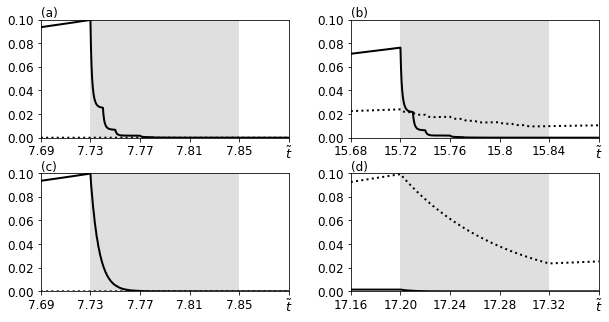

In [18]:
fig, axs = plt.subplots(2, 2, figsize=(10, 5))

axs[0,0].plot(ts_MTD2_rs_ui,x1_MTD2_rs_ui,'k-',linewidth=2,label=r'Sensitive Cancer $\tilde{x}_1$')
axs[0,0].plot(ts_MTD2_rs_ui,x2_MTD2_rs_ui,'k',linestyle='dotted',linewidth=2,label=r'Resistant Cancer $\tilde{x}_2$')
axs[0,0].set_xlim(7.73-4*0.01,7.73+16*0.01)
axs[0,0].set_ylim(0,0.1)

axs[0,1].plot(ts_MTD2_rs_ui,x1_MTD2_rs_ui,'k-',linewidth=2,label=r'Sensitive Cancer $\tilde{x}_1$')
axs[0,1].plot(ts_MTD2_rs_ui,x2_MTD2_rs_ui,'k',linestyle='dotted',linewidth=2,label=r'Resistant Cancer $\tilde{x}_2$')
axs[0,1].set_xlim(15.72-4*0.01,15.72+16*0.01)
axs[0,1].set_ylim(0,0.1)

axs[1,0].plot(ts_LDM2_rs_ui,x1_LDM2_rs_ui,'k-',linewidth=2,label=r'Sensitive Cancer $\tilde{x}_1$')
axs[1,0].plot(ts_LDM2_rs_ui,x2_LDM2_rs_ui,'k',linestyle='dotted',linewidth=2,label=r'Resistant Cancer $\tilde{x}_2$')
axs[1,0].set_xlim(7.73-4*0.01,7.73+16*0.01)
axs[1,0].set_ylim(0,0.1)

axs[1,1].plot(ts_LDM2_rs_ui,x1_LDM2_rs_ui,'k-',linewidth=2,label=r'Sensitive Cancer $\tilde{x}_1$')
axs[1,1].plot(ts_LDM2_rs_ui,x2_LDM2_rs_ui,'k',linestyle='dotted',linewidth=2,label=r'Resistant Cancer $\tilde{x}_2$')
axs[1,1].set_xlim(17.2-4*0.01,17.2+16*0.01)
axs[1,1].set_ylim(0,0.1)

axs[0,0].fill_between(np.array([0,7.73,7.73,7.73+0.01*12,7.73+0.01*12,25]),np.array([0.1,0.1,0.0,0.0,0.1,0.1]),0.1*np.ones(6),alpha=0.25,facecolor='grey',interpolate=True)
axs[0,1].fill_between(np.array([0,15.72,15.72,15.72+0.01*12,15.72+0.01*12,25]),np.array([0.1,0.1,0.0,0.0,0.1,0.1]),0.1*np.ones(6),alpha=0.25,facecolor='grey',interpolate=True)
axs[1,0].fill_between(np.array([0,7.73,7.73,7.73+0.01*12,7.73+0.01*12,25]),np.array([0.1,0.1,0.0,0.0,0.1,0.1]),0.1*np.ones(6),alpha=0.25,facecolor='grey',interpolate=True)
axs[1,1].fill_between(np.array([0,17.2,17.2,17.2+0.01*12,17.2+0.01*12,25]),np.array([0.1,0.1,0.0,0.0,0.1,0.1]),0.1*np.ones(6),alpha=0.25,facecolor='grey',interpolate=True)

axs[0,0].set_xticks([7.69,7.73,7.77,7.81,7.85,7.89])
axs[0,0].set_xticklabels(['7.69','7.73','7.77','7.81','7.85',r'$\tilde{t}$'],fontsize=12)
axs[0,1].set_xticks([15.68,15.72,15.76,15.8,15.84,15.88])
axs[0,1].set_xticklabels(['15.68','15.72','15.76','15.8','15.84',r'$\tilde{t}$'],fontsize=12)
axs[1,0].set_xticks([7.69,7.73,7.77,7.81,7.85,7.89])
axs[1,0].set_xticklabels(['7.69','7.73','7.77','7.81','7.85',r'$\tilde{t}$'],fontsize=12)
axs[1,1].set_xticks([17.16,17.2,17.24,17.28,17.32,17.36])
axs[1,1].set_xticklabels(['17.16','17.20','17.24','17.28','17.32',r'$\tilde{t}$'],fontsize=12)

for i in range(2):
    for j in range(2):
        axs[i,j].get_xticklabels()[-1].set_fontsize(13)

for i in range(2):
    for j in range(2):
        axs[i,j].set_yticks([0.00,0.02,0.04,0.06,0.08,0.10])
        axs[i,j].set_yticklabels(['0.00','0.02','0.04','0.06','0.08','0.10'],fontsize=12)

axs[0,0].text(7.69,0.1025,'(a)',fontsize=12)
axs[0,1].text(15.68,0.1025,'(b)',fontsize=12)
axs[1,0].text(7.69,0.1025,'(c)',fontsize=12)
axs[1,1].text(17.16,0.1025,'(d)',fontsize=12)

        
plt.subplots_adjust(hspace=0.3,wspace=0.25)